# Model Risk Management & Control

In [610]:
import pandas as pd
import numpy as np
import seaborn as sb 
import numpy.ma as ma
import scipy as sp
import matplotlib.pylab as plt

from scipy.stats import t
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics.regressionplots import plot_partregress_grid
# pip install arch
from arch.bootstrap import StationaryBootstrap
from arch.bootstrap import IIDBootstrap

In [611]:
#using pandas framework to get data
dataset = pd.read_csv('data.txt',sep="|",header=None)
dataset = pd.DataFrame(dataset)
#cleaning NAN from dataset
#dataset = dataset.dropna()
#dataset.fillna(0,inplace=True)
m = dataset.shape

In [612]:
#seasonal differencing
#source : Time series Econometrics, Jonh. D. Levendis, 1998, Springer
def D1(X):
    D1 = X - np.roll(X,4)
    return D1[4:]


<p style="background-color:#adebad;">   
Assume that you want to challenge the following regression specification to model the change in comsumption:

$$D\textbf(Consumption)_\mathrm{t}=\alpha + \beta_\mathrm{1}D(DPI)_\mathrm{t} + \beta_\mathrm{2}D(Unemployment)_\mathrm{t} + \epsilon_\mathrm{t}$$

Hereby, D() denotes the first differences, $\alpha$ the intercecpt, and the $\beta_\mathrm{i}$i the slope coefficients of the respective independent variables, $\epsilon_\mathrm{t}$ the residuals. 
</p>


<h2 style="background-color:#f0b375;">
<strong>Task1: Replication of results </strong>
</h2>
<p style="background-color:#adebad;">   
Compute the regression coefficients, standard errors, t-statistics, and p-values. 
Evaluate the accuracy of the regression.

In [613]:
# variables
CONS = np.array(pd.to_numeric(dataset[2][1:m[0]])) # consumption
DPI = np.array(pd.to_numeric(dataset[5][1:m[0]]))  # DPI
UNEM = np.array(pd.to_numeric(dataset[9][1:m[0]])) # unemployment


#differences Yt-Yt-1
#source : Time series Econometrics, Jonh. D. Levendis, 1998, Springer

D1_CONS = np.diff(CONS,1)
D1_DPI =  np.diff(DPI,1)
D1_UNEM = np.diff(UNEM,1)

# Z matrix
T=np.transpose([D1_CONS,D1_DPI,D1_UNEM])

Examining the data that goes to the regresion:

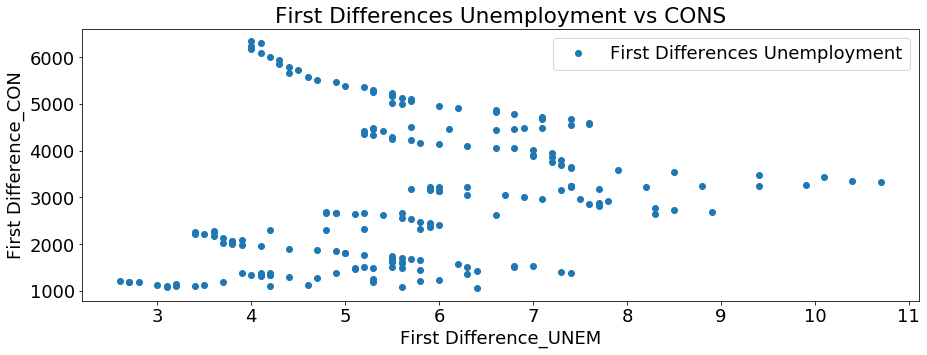

In [614]:
periods = np.linspace(1,m[0]-1,m[0]-1)
plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(UNEM,CONS,'o')
plt.title('First Differences Unemployment vs CONS')
plt.xlabel('First Difference_UNEM') 
plt.ylabel('First Difference_CON') 
plt.legend(['First Differences Unemployment'])
plt.show()

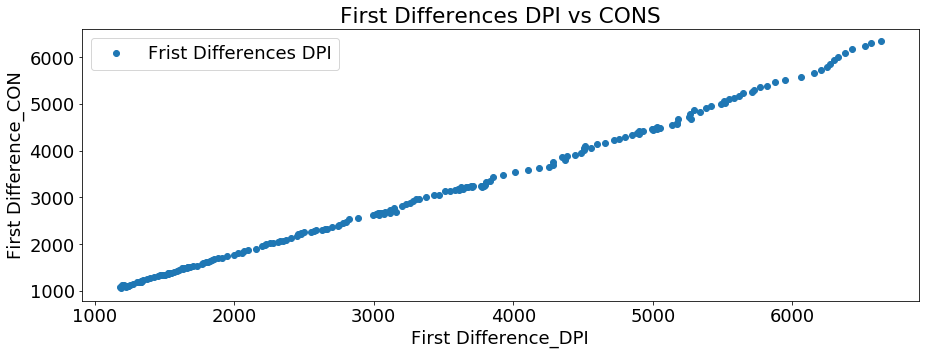

In [615]:
periods = np.linspace(1,m[0]-1,m[0]-1)

plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(DPI,CONS,'o')
plt.title('First Differences DPI vs CONS')
plt.xlabel('First Difference_DPI') 
plt.ylabel('First Difference_CON') 
plt.legend(['Frist Differences DPI'])
plt.show()

<p style="background-color:#adebad;">   
Ordinary Least Squares Regression implementation
    
Source: Linear Regression models, Chap. 7, University of Bern

In [616]:
class My_OLS:
    
    def __init__(self, n=0, Z=0, Y=0, p=0):  
        self.n = n
        self.Z = Z
        self.Y = Y
        self.p = p
    
    def B_hat(self):
        bb=np.linalg.inv(np.matmul(np.transpose(Z),Z))
        cc =np.matmul(np.transpose(Z),Y)
        B_hat = np.matmul(bb,np.transpose(cc))
        return B_hat

    def residuals(self):
        # hat matrix
        bb=np.linalg.inv(np.matmul(np.transpose(Z),Z))
        H=Z*bb*np.transpose(Z)
        residuals = np.matmul((-H+np.identity(n)), np.transpose(Y))
        return residuals
    
    def Y_hat(self):
        b= np.transpose(self.B_hat())
        Y_hat =np.sum(np.matmul(b, np.transpose(Z)),0) + self.residuals()
        return Y_hat

    def R_squared(self):
        R_squared = 1-np.sum(np.square(self.residuals()))/np.sum(np.square(Y-np.mean(Y)))
        return R_squared

    def std_err(self):
        s2 = np.sum(np.square(self.residuals()))/(n-(p+1))
        bb =np.linalg.inv(np.matmul(np.transpose(Z),Z))
        std_err= np.sqrt(np.abs(s2*bb))
        std_err = std_err.diagonal()
        return std_err

    def t_value(self):
        t_value = np.diagonal(np.divide(self.B_hat(),self.std_err()))
        return t_value

    def p_value(self):
        #Degrees of freedom
        t_value = self.t_value()
        N = n
        df = 2*N - 2
        #p-value after comparison with the t 
        p = 1 - t.cdf(t_value,df=df) 
        p_value = + 2*p
        return p_value


In [617]:
n=203
p = 2 # degrees of freedom
Y = D1_CONS # independent variable
Z  = np.transpose(np.matrix([np.ones(n), D1_DPI, D1_UNEM])) # design matrix
data = My_OLS(n,Z,Y,p) # initializing the class object

print("Regression coefficients:", data.B_hat())
print("standard errors:", data.std_err())
print("t-statistics:", data.t_value())
print("p-values:", data.p_value())
print("R_squaredValue:", data.R_squared())


Regression coefficients: [[ 16.284764  ]
 [  0.35566679]
 [-16.01488596]]
standard errors: [[1.91084117 0.04777901 3.79215691]]
t-statistics: [ 8.52230121  7.44399605 -4.22316016]
p-values: [4.44089210e-16 5.94635452e-13 1.99997021e+00]
R_squaredValue: 0.33470312951307557


<p style="background-color:#adebad;">   
Statsmodel OLS for validation of My_OLS class
    


In [618]:
#statistics approach: R-like
#used just validation my regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

df= pd.DataFrame(T, columns=['D1_CONS','D1_DPI','D1_UNEM'])
# Exogenous and endogenous data
y, X = dmatrices('D1_CONS ~ D1_DPI + D1_UNEM', data=df, return_type='dataframe') 
mod = sm.OLS(y, X)    # Describe model
res = mod.fit()       # Fit model

<p style="background-color:#adebad;"> 
Evaluate the accuracy of the regresion

<p style="background-color:#adebad;"> 
$R^{2}$ value    

The $R^{2}$ value of the regression is the fraction of the variation of the dependent variables ($Y$) that is accounted for (or predicted by) the independent ($X_\mathrm{1}$ and $X_\mathrm{2}$) variables.  Thus, the $R^{2}$ value can be used a a measurement of how close the data are to the fitted regression line. Therefore when $R^{2}$ is close to zero or $<<$ 1  indicates that the model explains somehow all the variability of the response data around its mean.


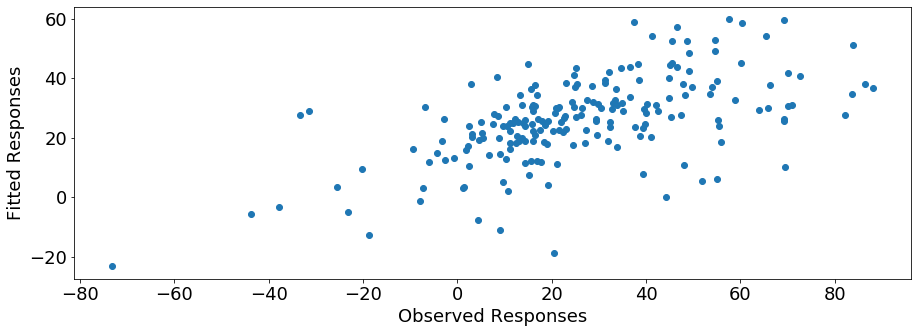

In [619]:
# Plotting fitted values by observed values
# graphically illustrates R-squared values for regression models.

pred_val = res.fittedvalues.copy()
true_val = df['D1_CONS'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.scatter(true_val, pred_val)
plt.xlabel("Observed Responses")
plt.ylabel("Fitted Responses")
plt.show()


The regression model on the accounts for 33% of the variance. The more variance that is accounted for by the regression model the closer the data points will fall to the fitted regression line. Theoretically, if a model could explain 100% of the variance, the fitted values would always equal the observed values and, therefore, all the data points would fall on the fitted regression line.

However $R^{2}$ values cannot determine whether the coefficient estimates and predictions are biased, which is why you must assess the residual plots.
$R^{2}$ values do not indicate whether a regression model is adequate. 
We can have a low $R^{2}$ value value for a good model, or a high $R^{2}$ value value for a model that does not fit the data.



However $R^{2}$ values cannot determine whether the coefficient estimates and predictions are biased, which is why you must assess the residual plots.
$R^{2}$ values do not indicate whether a regression model is adequate. 
We can have a low $R^{2}$ value value for a good model, or a high $R^{2}$ value value for a model that does not fit the data.

<p style="background-color:#adebad;"> 
Residual Plots and Scatterplots

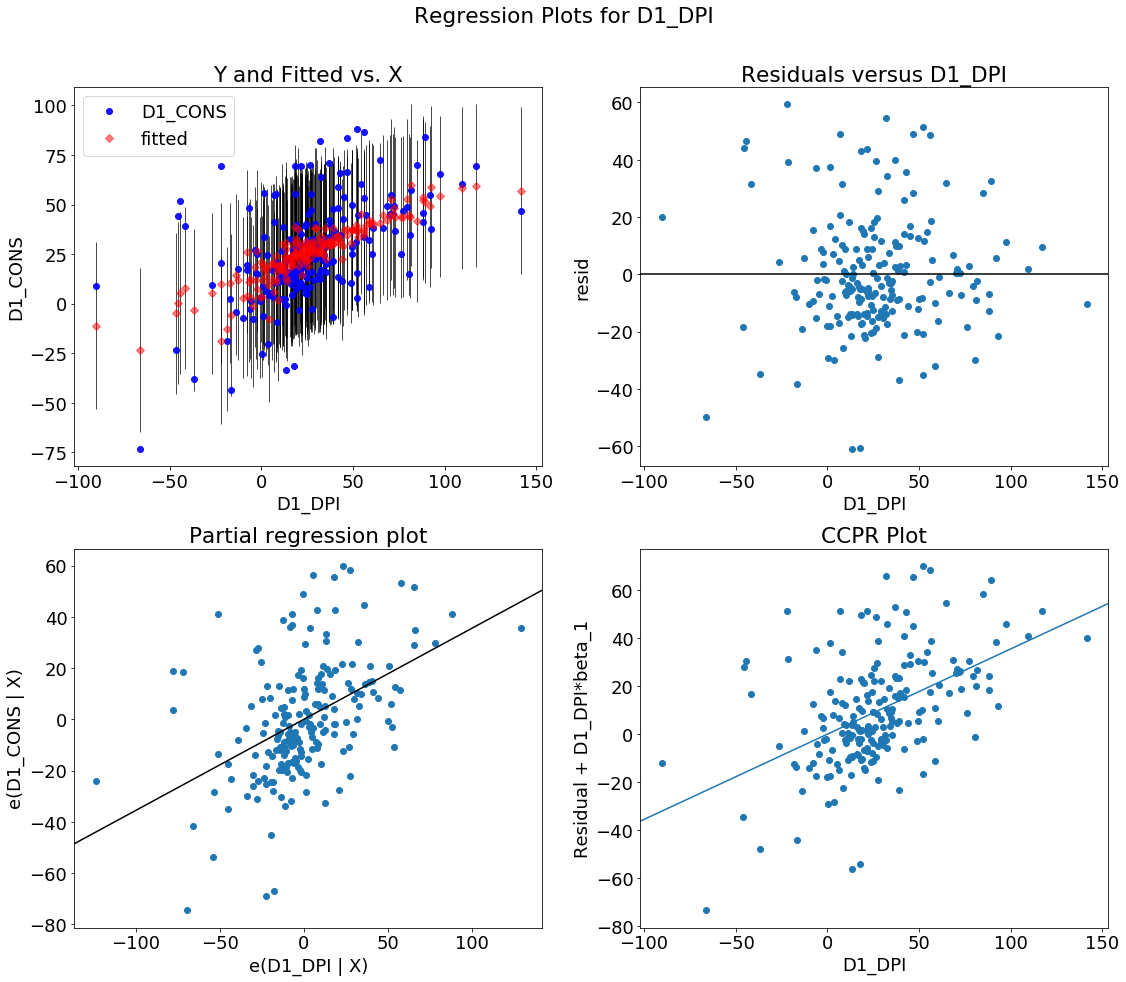

In [620]:
fig = plt.figure(figsize=(16, 14))
sm.graphics.plot_regress_exog(res, 'D1_DPI', fig=fig)
plt.show()

<p style="background-color:#adebad;"> 
Scatterplot and Residual Analysis for D1_UNEM ($X_\mathrm{1}$)

On a first instance, if we focus our attention on the partial regression plot (Y vs $X_\mathrm{1}$) it is possible to observe an important linear data pattern on the data. As well, the dots are densely scattered around the line, thus then the relationship can be assumed to be strong.

Regarding the residual analysis of D1_UNEM ($X_\mathrm{1}$), it is clear that the Residuals versus $X_\mathrm{1}$ plot exibit a random pattern, thus this might show that the assumption of linear regression model will accurate for the above data. 

Next, the CCPR plot examines the influence of the Unemployment($X_\mathrm{2}$) in the residuals vs. $X_\mathrm{1}$ relationship. The residuals in this plot, seem to be still reasonable random, so the linearity assumption is still present.

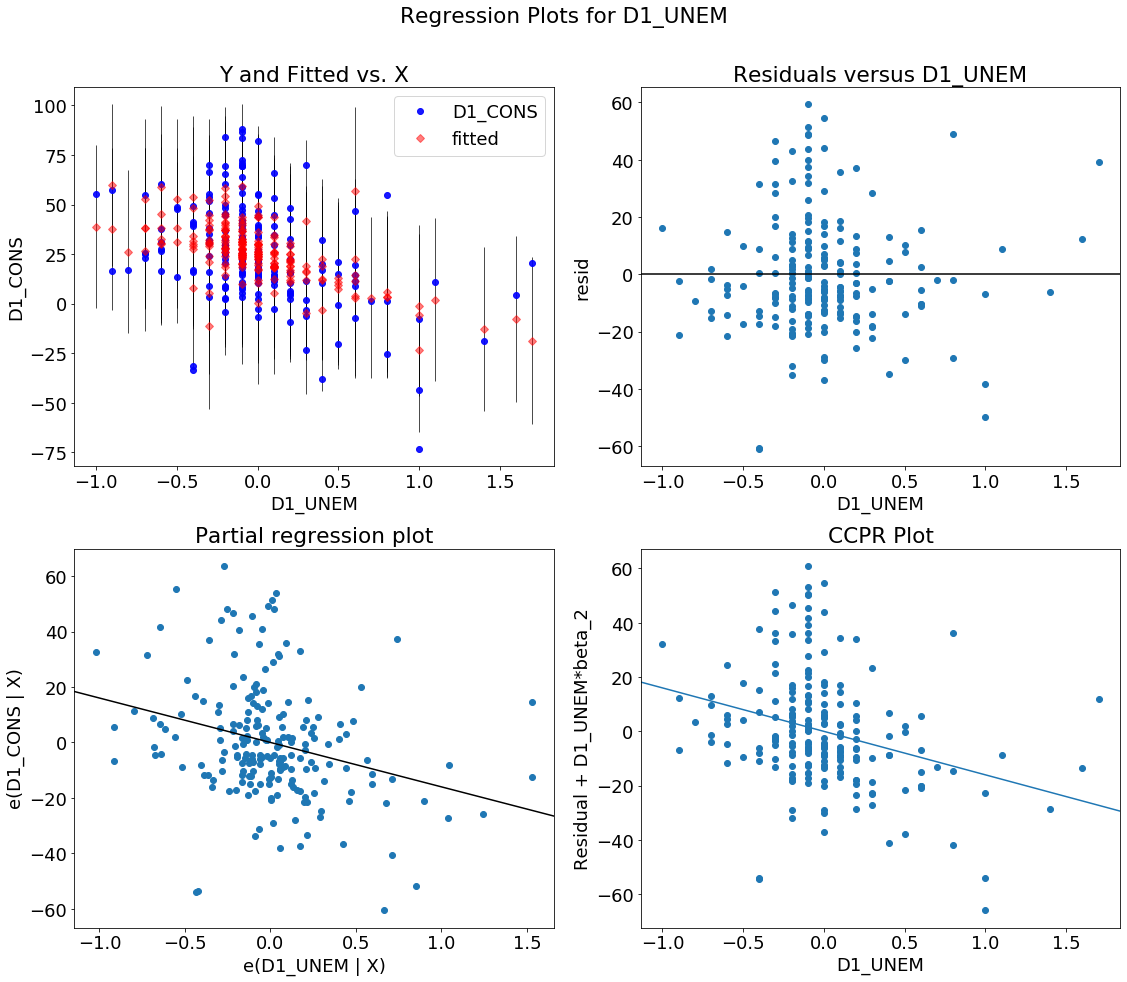

In [621]:
fig = plt.figure(figsize=(16, 14))
sm.graphics.plot_regress_exog(res, 'D1_UNEM', fig=fig)
plt.show()

<p style="background-color:#adebad;"> 
Scaterplott and Residual Analysis for D1_UNEM ($X_\mathrm{2}$)

On a first instance, if we focus our attention on the partial regression plot (Y vs $X_\mathrm{2}$) it is possible to observe a soft linear data pattern on the data and a negative slope. Furthermore the dots are scattered around the line, thus there is evidience of a relationship between Y and $X_\mathrm{2}$.

Regarding the residual analysis of D1_UNEM ($X_\mathrm{2}$), it is clear that the Residuals versus $X_\mathrm{2}$ plot does not exibit a random pattern, this might show that the assumption of linear regression model will not be so accurate for the above data. Thus,if we examine the Tukey's test for nonadditivity (Tukey, 1949) for checking the curvature as a function of the mean. It's adding a quadratic term to the model and the p-value is the probability that the coefficient of the quadratic term is 0

Next, the CCPR plot examines the influence of the Unemployment($X_\mathrm{1}$) in the residuals vs. $X_\mathrm{2}$ relationship. The residuals in this plot, are not random so the linearity is weak for the data  $X_\mathrm{2}$.


Finally, if we would like to have more criteria to asses the linearity assumption of the whole data we could conduct the Harvey-Collier multiplier test. Thi is a multiplier test for Null hypothesis that the linear specification is correct. 

In [622]:
import statsmodels.stats.api as sms
sms.linear_harvey_collier(res)

Ttest_1sampResult(statistic=5.658096591771853, pvalue=5.277698068599408e-08)

<p style="background-color:#adebad;"> 
Normality and homoscedasticity analysis by the residuals

For examining how the residuals depart from normality visually, we can do a normal probability plot as follows:

0.9575323620314404

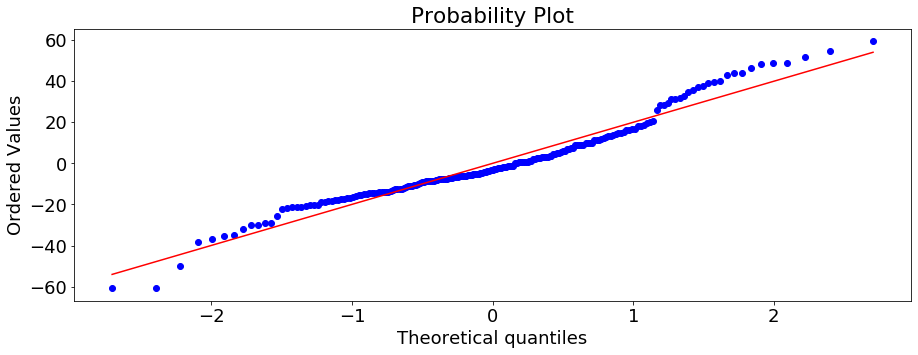

In [623]:
fig, ax = plt.subplots(figsize=(15,5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

Finally for testing equal variance, with different alternative hypotheses we will use the Breusch-Pagan.

In [624]:
_, pval, __, f_pval = sms.diagnostic.het_breuschpagan(residual, df[['D1_DPI', 'D1_UNEM']])
print("pvalue:",pval,"fvalue:", f_pval)

pvalue: 0.001260771830868266 fvalue: 0.0050676896338306835


The small p-value shows that there is violation of homoscedasticity.
If we go back to the linearity test, the p-value was small too, thus the linearity hypothesis is rejected. This was seen already from the residuals vs. $X_\mathrm{2}$ plot. 
Usually assumption violations are not independent of each other, so one could lead to another.

From our regression analysis, we can conclude that both linearity and homoscedasticity are not met.
Hence, we have two choices either we use any data transformations such as log, Box-Cox power transformations or we use a quadratic term to get a better regression outcome.

<p style="background-color:#adebad;"> 
Standar error, t statistic and p-value

The standard error ($\sigma_\mathrm{est}$) is an estimate of the standard deviation of the regression coefficient. It can be thought of as a measure of the precision with which the regression coefficient is measured. If a coefficient is large compared to its standard error, then it is probably different from 0. Thus $\beta_\mathrm{2}$ can be the estimator with a lower precision than  $\beta_\mathrm{1}$ and $\alpha$ if we compare their $\sigma_\mathrm{est}$.

Next, since we know the t statistic depends on the $\sigma^{2}$, the p-value is determined by comparing the t statistic with the Student's t distribution. The Student's t distribution describes how the mean of a sample with a certain number of observations (n) is expected to behave.

The p-value for each term is the probability of seeing a large t value in a collection of random data in which the variable had no effect and it tests the null hypothesis that the coefficient is equal to zero or has no effect. 

A low p-value (< 0.05) indicates a rejection of the null hypothesis.  So by examining the low p-values of our estimators we can conclude that they are likely to be a meaningful addition to the model because variations in the estimors's values are related to changes in the response variable.

On the other hand, a larger p-value suggests that changes in the predictor are not associated with changes in the response.

Finally, the size of the p-value for an estimator says nothing about the size of the effect that variable ($X_\mathrm{1}$ or $X_\mathrm{2}$) has on  $Y$.


<h2 style="background-color:#f0b375;">
<strong>Task2: Outlier Detections </strong>
 </h2>
<p style="background-color:#adebad;">   
Examine the time series of the residuals for outliers. Use Tukey’s test for this,
i.e. observations are considered outliers if they fall outside of the following
interval:
$$[Q_\mathrm{0.25}(x) − 1.5 × IQR, Q_\mathrm{0.75}(x) + 1.5 × IQR]$$
where $Q_\mathrm{p}(x)$  denotes the pth quantile of x and IQR denotes the interquartile
range. Comment on the number of outliers and what this implies for the inter-
pretation of the regression results.



In [625]:
def detect_outliers(residuals):
    IQR = np.quantile(residuals,0.75)-np.quantile(residuals,0.25)
    I1 = np.quantile(residuals,0.25)-1.5*IQR
    I2 = np.quantile(residuals,0.75)+1.5*IQR
    outliers = np.where((residuals < I1)|(residuals>I2), 0,1)
    return outliers,I1,I2

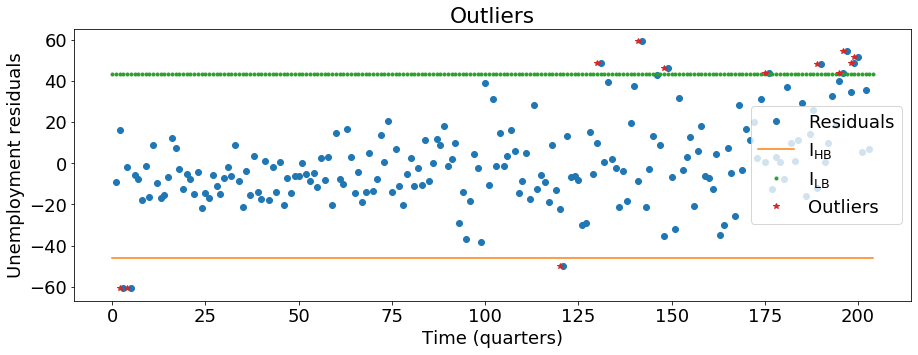

In [627]:
periods = np.linspace(1,m[0]-2,m[0]-2)
data = My_OLS(n,Z,Y)
r = np.array(data.residuals())
[outliers,I1,I2] = detect_outliers(r)
#masked array to plot
plot_out = ma.array(np.transpose(r), mask = np.array(outliers))
#figure
plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(periods,np.transpose(r),'o',I1*np.ones(m[0]),'-',I2*np.ones(m[0]),'.',plot_out, '*')
plt.title('Outliers')
plt.xlabel('Time (quarters)') 
plt.ylabel('Unemployment residuals') 
plt.legend(['Residuals','I$_\mathrm{HB}$','I$_\mathrm{LB}$','Outliers'])
plt.show()  

<p style="background-color:#adebad;">   
Comment on the number of outliers and what this implies for the interpretation of the regression results.

Outliers account for approximately 6% of the sample data, thus they have a moderate effect on the accuracy of the regression. We can see that early in time there are very few outliers and that outliers are atypical (in the sense that their residuals are much larger than usual), meaning that our regression fits the data well. As time progresses, there are more outliers, and the residuals increase in absolute value, meaning that the regression fit worsens.  
Furthermore, some of these outliers specially the ones far from $I_\mathrm{LB}$ and $I_\mathrm{HB}$ that can be considered as influential points.  An influential point may represent bad data, possibly the result of measurement error.
Finally we coudl improve 
    Compare the decisions that would be made based on regression equations defined with and without the influential point. 

<h2 style="background-color:#f0b375;">
<strong>Task3: Autocorrelation of Residuals </strong>
 </h2>
<p style="background-color:#adebad;">   
Calculate the Durbin-Watson (DW) statistic of the residuals. The DW statistic
is defined as:
    $$DW = \frac{\sum^{T}_\mathrm{t=2}(\epsilon_\mathrm{t}-\epsilon_\mathrm{t-1})^{2}}{\sum^{T}_\mathrm{t=1} \epsilon^{2}_\mathrm{t}} $$
where T is the length of the sample and  t are the residuals of the regression
above. Comment on the impact of autocorrelation of the errors on the regression.

The Hypotheses for the Durbin Watson test are:
$H_\mathrm{0}$ = no first order autocorrelation.
$H_\mathrm{1}$ = first order correlation exists.
(For a first order correlation, the lag is one time unit).

Assumptions are:
1. That the errors are normally distributed with a mean of 0.
2. The errors are stationary.


In [628]:
def DW(r):
    num = np.square(r- np.roll(r,1))
    DW = (np.sum(num,1)-num[0,0])/np.sum(np.square(r))
    return DW

In [629]:
data = My_OLS(n,Z,Y)
r = np.array(data.residuals())
print("DW-static",DW(r))

DW-static [1.76709637]


<p style="background-color:#adebad;"> 
Comment on the impact of autocorrelation of the errors on the regression.

Autocorrelation, also know as serial correlation, is the correlation where the error terms in a time series transfer from one period to another. In other words, the error for one time period ($q_\mathrm{t}$) is correlated with the error for a subsequent time period $q_\mathrm{t+1}$.
    
For instance, an underestimate on $q_\mathrm{t}$ profits can result in an underestimate of profits for $q_\mathrm{t+1}$. In the context of a linear regresion, this can cause some issues like:

1. Inefficient Ordinary Least Squares Estimates and any forecast based on those estimates. Inefficient $\beta_\mathrm{r}$ can perform well, but require much larger sample sizes to do so.
2. Exaggerated goodness of fit, in the case of a time series with positive serial correlation with independent variables that grow over time.
3. Can yield $\sigma_\mathrm{est}$ that are too small.
4. T-statistics that are too large.
5. False positives for significant regression coefficients making a regression coefficient appear to be statistically significant when it is not.   

For detecting this serial autocorreltaion, the Durbin-Watson statistic is a test used to detect the autocorrelation of the errors in a linear regresion.  If the DW is defined as  approximately equal to $$2(1 −  \rho^\mathrm{})$$ where $\rho^\mathrm{} $ is the sample autocorrelation of the residuals, the value of DW = 2 indicates no serial correlation.

Following this idea, the most common form of autocorrelation is first-order serial correlation which can either be positive or negative.
    
Positive serial correlation is where a positive error in one period ($q_\mathrm{t}$) carries over into a positive error for the following period ($q_\mathrm{t+1}$).  Thus if DW is $<<$ 2, there is an evidence of positive serial correlation. Furthermore, if DW $<$1.0 this indicates a postive serial correlation between them. 

Finally, if DW is $>$ 2 successive error terms indicate a negative serial correlation between them. Negative serial correlation is where a negative error in one period ($q_\mathrm{t}$) carries over into a negative error for the following period ($q_\mathrm{t+1}$). In the context ofregressions, this might imply an underestimation of the level of statistical significance. 

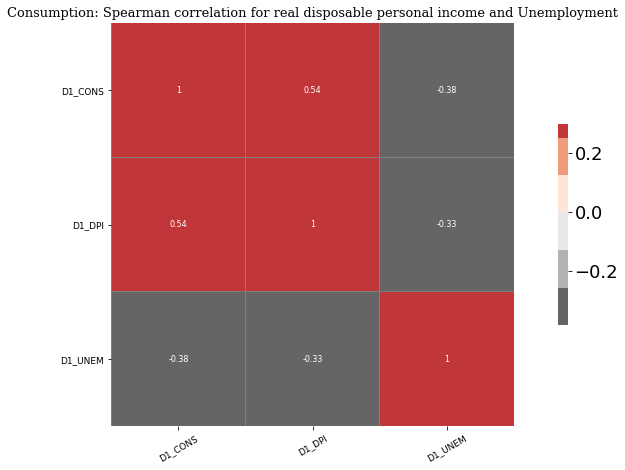

In [630]:
#correlogram
#source = Computing and plotting correlograms in python (https://hal.archives-ouvertes.fr/hal-02327797/document)
corr = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(15, 8))
cmap="RdYlBu" # for Kendall correlogram
pal = sb.color_palette("RdGy_r") # for
#Spearman correlogram reversed color palette
cmap=pal # for Spearman correlogram
# Drawing the correlogram heatmap
sb.heatmap(corr, cmap=cmap, vmax=0.3, center=0, annot=True, annot_kws={"size":8}, square=True, linewidths=.05, linecolor='grey', cbar=True, mask=False, cbar_kws={"shrink":.5}, )
# = Adding titles, adjusting subplots and labelling x/y ticks
plt.title('Consumption: Spearman correlation for real disposable personal income and Unemployment',fontsize=13, fontfamily='serif')
plt.subplots_adjust(bottom=0.20,top=0.90, right=0.90, left=0.10)
plt.xticks(rotation=30, size=9)
plt.yticks(rotation=0, size=9)
plt.show()

From the DW value we conclude that there is a positive serial correlation in our regression term. As rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal [1] in time series na. Values under 1 or more than 3 are a definite cause for concern.
As well the correlogram gives us an idea of the pairs of data that show a serial correlation thus the DPI ($X_\mathrm{1}$) erros tend to be serially correlated.

<h2 style="background-color:#f0b375;">
<strong>Task4: Bootstrapping of Standard Errors </strong>
 </h2>
<p style="background-color:#adebad;">   
Recalculate the standard errors of the regression coefficients using bootstrapping. For the bootstrap, generate 10’000 samples, each of size T, from the original data, using random sampling with replacement. When you compare the bootstrapped standard errors to the default standard errors, what differences can you observe? What are the implications?

First we will fit a regression model as in task1.
Although I developped a code to do manually bootstrapping of the data, it was computationaly slow and cumbersome, so I decided to used the appropiate python libraries for speeding up the calculation.
For the implementation, we have a sample of n observations $df_\mathrm{i}$ = ($y_\mathrm{i}$, $x_\mathrm{i}1$ , $x_\mathrm{i2}$ , . . . , $x_\mathrm{ik}$ ), $i = 1, . . . , n$.
In random-x resampling, we select $n_\mathrm{B}$ bootstrap samples of the $df_\mathrm{i}$ , fitting the model and saving the coefficients from each bootstrap sample.

In [631]:
#wrapper function to the OLS regression
def OLS_wrap(endog, exog):
    return sm.OLS(endog, exog).fit(disp=0).params

In [632]:
#source:https://arch.readthedocs.io/en/latest/bootstrap/bootstrap_examples.html
#using the arch library to perform bootstrapping.

# Initialize with entropy from random.org
entropy = [877788388, 418255226, 989657335, 69307515]
#random state for the bootstrapping
rs = np.random.RandomState(entropy)
# design matrix to do the OLS regression
y, X = dmatrices('D1_CONS ~ D1_DPI + D1_UNEM', data=df, return_type='dataframe') 
#bootstrap using uniform resampling
bs = IIDBootstrap(endog=y, exog=X)
#estimators = bs(OLS_wrap, 10000)
#getting the covariance from 10k samples
cov = bs.cov(OLS_wrap, 10000)
# transforming to pandas dataframe
cov = pd.DataFrame(cov, index=exog.columns, columns=exog.columns)
#getting the bootstrapped standard errors
se = pd.Series(np.sqrt(np.diag(cov)), index=exog.columns)
print("bootstrapped standar errors:",se)


bootstrapped standar errors: Const      2.296500
D1_DPI     0.055568
D1_UNEM    4.206422
dtype: float64


In [633]:
#finding the optimal block length for the stationary bootstrap.
from arch.bootstrap import optimal_block_length
opt = optimal_block_length(y ** 2)
print(opt)

         stationary   circular
D1_CONS   18.601815  21.293763


              Alpha
count  10000.000000
mean      16.343470
std        3.770095
min        4.732107
25%       13.751129
50%       16.233972
75%       18.834733
max       31.942562


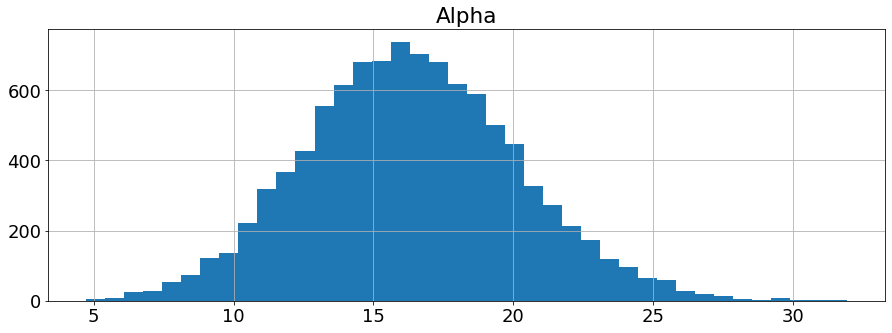

In [607]:
bs1 = StationaryBootstrap(19, y, X, random_state=rs)
results = bs1.apply(OLS_wrap, 10000)
alpha = pd.DataFrame(results[:, 0], columns=['Alpha'])
fig = alpha.hist(bins=40)
print(alpha.describe())

              Beta1
count  10000.000000
mean       0.356681
std        0.090990
min        0.044289
25%        0.293928
50%        0.349840
75%        0.412390
max        0.753435


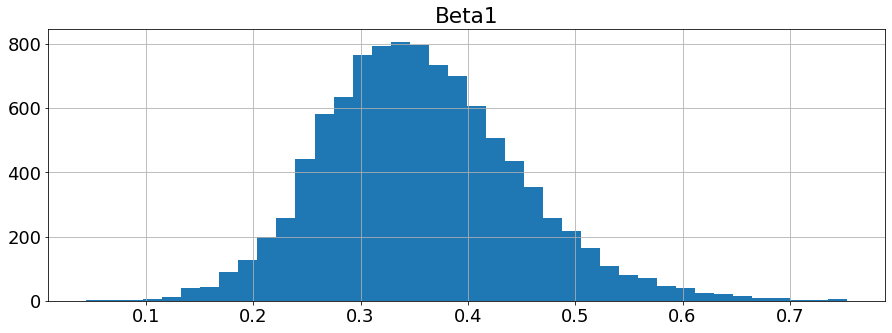

In [608]:
beta1 = pd.DataFrame(results[:, 1], columns=['Beta1'])
fig = beta1.hist(bins=40)
print(beta1.describe())

              Beta2
count  10000.000000
mean     -16.341228
std        4.583174
min      -39.372141
25%      -19.217405
50%      -15.928085
75%      -13.041903
max       -1.936210


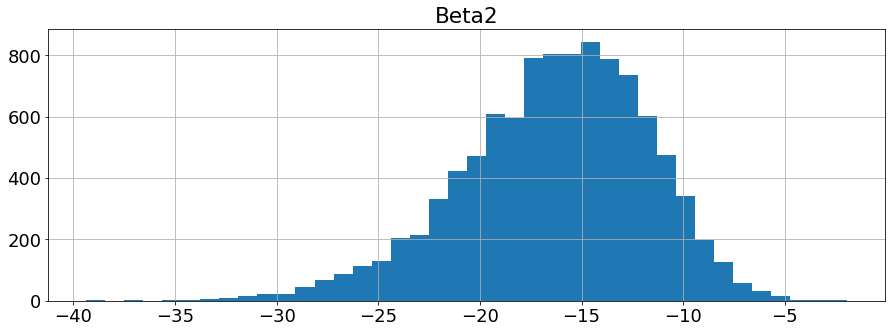

In [609]:
beta2 = pd.DataFrame(results[:, -1:], columns=['Beta2'])
fig = beta2.hist(bins=40)
print(beta2.describe())

<p style="background-color:#adebad;">  
 When you compare the bootstrapped standard errors to the default standard errors, what differences can you observe? What are the implications?
    
When the $\sigma_\mathrm{est}$ is compared with the $\sigma_\mathrm{estB}$ , this one becomes larger. From the histograms plots of the estimators we could see that the standard deviation is higher. We could bootstrap with bigger number of samples to try to remediate this discrepancy, as well the confidence intervals appear to be wider.
    
The same will happen for the median than for the $\mu$ of any of the data of our regression, if we bootstrapped it.
This is generally true for normally distributed data — the median has about 25% more variability than the mean, but for non-normally distributed data, the median is often more precise than the mean.


<p style="background-color:#adebad;"> 
Implications

First, bootstrapping wont be so useful if we have not a large observed dataset, which in our case can be a concern.

Second, we can consider two sources of error in bootstrap inference[2]:     
1. The error induced by using a particular sample S to represent the population
2. The sampling error produced by failing to enumerate all bootstrap samples. The latter source of error can be controlled by making the number of bootstrap replications R sufficiently large.
    
In the case of the confidence intervals: The T statistic is asssumed to be normally distributed and the bootstrap is used to estimate the sample variance and to consturct a 100(1-$\alpha$)-percent confidence interval. Thus, to obtain sufficiently accurate 95-percent bootstrap confidence intervals, the number of bootstrap samples should be in around 1000 or more.
    
    


<p style="background-color:#adebad;">  
References

[1]  Field, A. (2009) Discovering Statistics Using SPSS. 3rd Edition, Sage Publications Ltd., London. 

[2] https://statweb.stanford.edu/~owen/courses/305a/FoxOnBootingRegInR.pdf